In [1]:
#%pip install -U Pyarrow

Note: you may need to restart the kernel to use updated packages.


In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:30:42_Pacific_Standard_Time_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [2]:
%pip install -U tensorflow[and-cuda]

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

In [10]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get("mean_absolute_error"))
        self.val_losses.append(logs.get("val_mean_absolute_error"))

        plt.clf()
        plt.plot(self.x, self.losses, label="mean_absolute_error")
        plt.plot(self.x, self.val_losses, label="val_mean_absolute_error")
        plt.legend()
        plt.pause(0.01)

In [4]:
import pandas as pd

DATAPATH = "contest/data"

d_csv = pd.read_csv(f"{DATAPATH}/fried_noodles_dataset.csv")
d_csv

,filename,meat,veggie,noodle
0,0-food_tray-10-top.jpg,0,0,0
1,0-food_tray-12-top.jpg,0,0,0
2,0-food_tray-13-top.jpg,0,0,0
3,0-food_tray-14-top.jpg,0,0,0
4,0-food_tray-16-top.jpg,0,0,0
...,...,...,...,...
1851,2020_09_18-266-top.jpg,15,15,60
1852,2020_09_18-267-top.jpg,15,15,60
1853,2020_09_18-268-top.jpg,15,15,60
1854,2020_09_18-269-top.jpg,15,15,60


In [5]:
from sklearn.model_selection import train_test_split

train_set, validation_set = train_test_split(d_csv, train_size=0.6)

train_set

,filename,meat,veggie,noodle
1129,2020_01_08-fried_noodles-set_7-2.jpg,4,0,0
1100,2020_01_08-fried_noodles-set_3-7.jpg,0,13,0
1807,2020_09_18-211-top.jpg,8,0,55
401,2019_11_08-fried_noodles-set_20-5.jpg,3,9,59
623,2019_11_18-fried_noodles-set_3-9.jpg,5,12,26
...,...,...,...,...
936,2019_12_03-fried_noodles-set_13-8.jpg,18,7,62
1230,2020_01_23-fried_noodles-set_10-6.jpg,3,10,11
605,2019_11_18-fried_noodles-set_1-3.jpg,0,12,0
731,2019_11_18-fried_noodles-set_15-7.jpg,2,37,54


ref1: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

1. read train_set
2. use ImageGenerator to preprocess the image
3. train the model using the result from the image
4. evaluate on validation_set

In [6]:
from keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, rotation_range=180, horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    target_size=(150, 200),
)

test_dategen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = train_datagen.flow_from_dataframe(
    validation_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    target_size=(150, 200),
)

Found 1113 validated image filenames.
Found 743 validated image filenames.


In [7]:
from keras.models import Model
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    BatchNormalization,
    Conv2D,
    MaxPool2D,
)
from keras.optimizers import Adam

inputIm = Input(
    shape=(
        150,
        200,
        3,
    )
)
conv1 = Conv2D(64, 3, activation="relu")(inputIm)
conv1 = Conv2D(64, 3, activation="relu")(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPool2D()(conv1)

conv2 = Conv2D(128, 3, activation="relu")(pool1)
conv2 = Conv2D(128, 3, activation="relu")(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPool2D()(conv2)

conv3 = Conv2D(256, 3, activation="relu")(pool2)
conv3 = Conv2D(256, 3, activation="relu")(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPool2D()(conv3)

conv4 = Conv2D(512, 3, activation="relu")(pool3)
conv4 = Conv2D(512, 3, activation="relu")(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPool2D()(conv4)

"""
conv5 = Conv2D(1024,3,activation='relu')(pool4)
conv5 = Conv2D(1024,3,activation='relu')(conv5)
conv5 = BatchNormalization()(conv5)
pool5 = MaxPool2D()(conv5)
"""
flat = Flatten()(conv4)  # can be conv5

dense1 = Dense(512, activation="sigmoid")(flat)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512, activation="sigmoid")(dense1)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512, activation="sigmoid")(dense1)
dense1 = Dropout(0.5)(dense1)
output = Dense(3)(dense1)

model = Model(inputs=inputIm, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mean_absolute_error"]
)

In [8]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "first_food.h5",
    verbose=1,
    monitor="val_mean_absolute_error",
    save_best_only=True,
    mode="min",
)
plot_losses = PlotLosses()

C:\Users\tanat\AppData\Local\Temp\ipykernel_28932\2873913361.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/60


35/35 [==============================] - ETA: 0s - loss: 2407.7678 - mean_absolute_error: 25.6561
Epoch 1: val_mean_absolute_error improved from inf to 26.29305, saving model to first_food.h5


C:\Users\tanat\miniconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


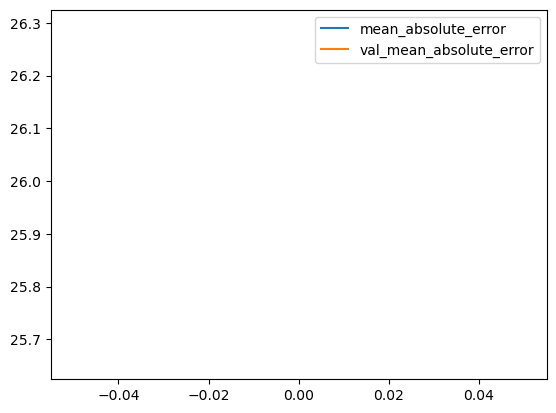

35/35 [==============================] - 126s 4s/step - loss: 2407.7678 - mean_absolute_error: 25.6561 - val_loss: 2427.2935 - val_mean_absolute_error: 26.2931
Epoch 2/60
35/35 [==============================] - ETA: 0s - loss: 2189.1858 - mean_absolute_error: 24.3486
Epoch 2: val_mean_absolute_error improved from 26.29305 to 25.37754, saving model to first_food.h5


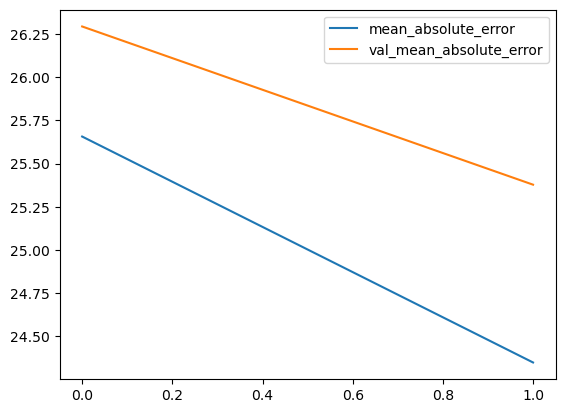

35/35 [==============================] - 120s 3s/step - loss: 2189.1858 - mean_absolute_error: 24.3486 - val_loss: 2281.0410 - val_mean_absolute_error: 25.3775
Epoch 3/60
35/35 [==============================] - ETA: 0s - loss: 2056.6226 - mean_absolute_error: 23.6360
Epoch 3: val_mean_absolute_error improved from 25.37754 to 24.86779, saving model to first_food.h5


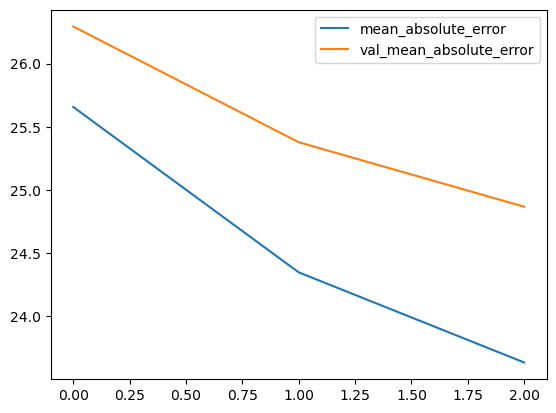

35/35 [==============================] - 125s 4s/step - loss: 2056.6226 - mean_absolute_error: 23.6360 - val_loss: 2186.1638 - val_mean_absolute_error: 24.8678
Epoch 4/60
35/35 [==============================] - ETA: 0s - loss: 1985.5396 - mean_absolute_error: 23.3229
Epoch 4: val_mean_absolute_error improved from 24.86779 to 24.56596, saving model to first_food.h5


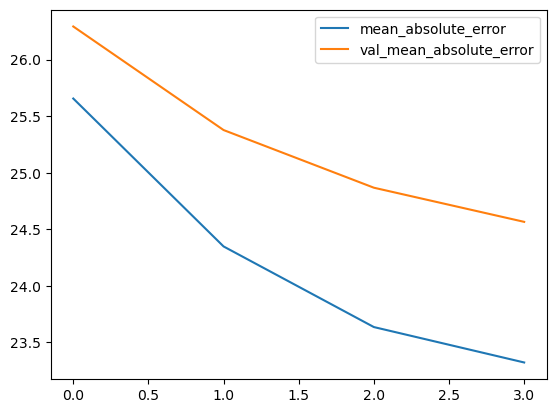

35/35 [==============================] - 120s 3s/step - loss: 1985.5396 - mean_absolute_error: 23.3229 - val_loss: 2125.1091 - val_mean_absolute_error: 24.5660
Epoch 5/60
35/35 [==============================] - ETA: 0s - loss: 1935.3265 - mean_absolute_error: 23.1094
Epoch 5: val_mean_absolute_error improved from 24.56596 to 24.37058, saving model to first_food.h5


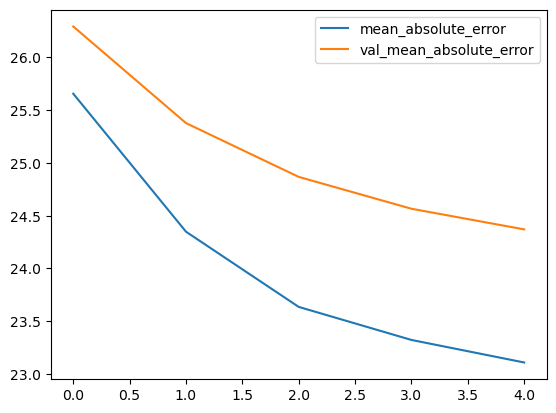

35/35 [==============================] - 120s 3s/step - loss: 1935.3265 - mean_absolute_error: 23.1094 - val_loss: 2083.8040 - val_mean_absolute_error: 24.3706
Epoch 6/60
 7/35 [=====>........................] - ETA: 1:31 - loss: 1488.0277 - mean_absolute_error: 20.1903

KeyboardInterrupt: 

In [11]:
# Train the Model
model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, plot_losses],
)